## Introduction

First attempt at Port Keguro Kaggle competition 

In [147]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

#allows printing of all data in cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [148]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [149]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [150]:
train.tail()


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,...,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,...,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,...,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,...,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,...,4,4,3,8,0,1,0,0,0,0


In [151]:
train.shape, test.shape

((595212, 59), (892816, 58))

Check for missing values

In [153]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


In [154]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
test.drop(vars_to_drop, inplace=True, axis=1)
#Replace with median
median_values = train.median(axis=0)
train = train.fillna(median_values, inplace=True)

### Imbalanced Classes

In [155]:
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The target variable is highly imbalanced, could use oversampling records with target=1, undersampling with target = 0 or Stratified sampling in sklearn; we will choose the latter 

In [156]:
targets = train['target'].values

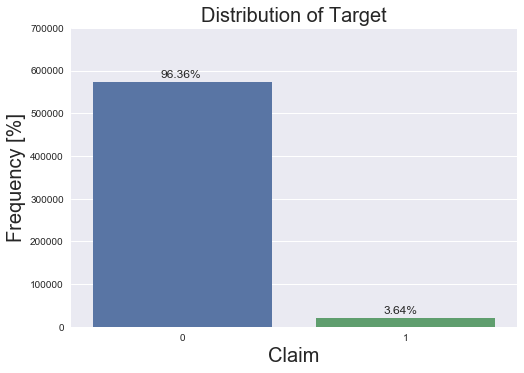

In [157]:
sns.set(style="darkgrid")
ax = sns.countplot(x = targets)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x()+ 0.3, p.get_height()+10000))
plt.title('Distribution of Target', fontsize=20)
plt.xlabel('Claim', fontsize=20)
plt.ylabel('Frequency [%]', fontsize=20)
ax.set_ylim(top=700000);

### Encoding categorical variables

In [158]:
# divides all features in to 'bin', 'cat' and 'etc' group.

feature_list = list(train.columns)
def groupFeatures(features):
    features_bin = []
    features_cat = []
    features_etc = []
    for feature in features:
        if 'bin' in feature:
            features_bin.append(feature)
        elif 'cat' in feature:
            features_cat.append(feature)
        elif 'id' in feature or 'target' in feature:
            continue
        else:
            features_etc.append(feature)
    return features_bin, features_cat, features_etc

feature_list_bin, feature_list_cat, feature_list_etc = groupFeatures(feature_list)
print("# of binary feature : ", len(feature_list_bin))
print("# of categorical feature : ", len(feature_list_cat))
print("# of other feature : ", len(feature_list_etc))

# of binary feature :  17
# of categorical feature :  12
# of other feature :  26


In [159]:
def oneHotEncode_dataframe(df, features):
    for feature in features:
        temp_onehot_encoded = pd.get_dummies(df[feature])
        column_names = ["{}_{}".format(feature, x) for x in temp_onehot_encoded.columns]
        temp_onehot_encoded.columns = column_names
        df = df.drop(feature, axis=1)
        df = pd.concat([df, temp_onehot_encoded], axis=1)
    return df

In [160]:
train = oneHotEncode_dataframe(train, feature_list_cat)
test = oneHotEncode_dataframe(test, feature_list_cat)

### Define the gini metric

In [161]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

### XGBoost

In [162]:
from sklearn.model_selection import StratifiedShuffleSplit
n_split = 3
SSS = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=1989)

In [163]:
#initial params
params = {
    'min_child_weight': 10.0,
    'max_depth': 3,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.040,
    'gamma': 0.65,
    'num_boost_round' : 700
}

In [164]:
X = train.drop(['id', 'target'], axis=1).values
y = train.target.values
test_id = test.id.values
test = test.drop('id', axis=1)

In [165]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [166]:
SSS.get_n_splits(X, y)

3

In [167]:
for train_index, test_index in SSS.split(X, y):
    print("TRAIN: ", train_index, "TEST: ", test_index)

TRAIN:  [328711 163933   8568 ..., 240844   5173 116969] TEST:  [325693 153828 230906 ...,  84130 126092 198447]
TRAIN:  [212428 582223  16120 ..., 223058 504099 355375] TEST:  [  1406   4735 206750 ..., 149629  15422 116995]
TRAIN:  [299768 243373 258750 ..., 446885 204518 494026] TEST:  [373302 277879 127441 ...,  24065 440856 534375]


In [168]:
for i, (train_index, test_index) in enumerate(SSS.split(X, y)):
    print('------# {} of {} shuffle split------'.format(i + 1, n_split))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    
    # Convert splited data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(test.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! 
    model = xgb.train(params, d_train, 200, watchlist, 
                      early_stopping_rounds=100, feval=gini_xgb, maximize=True, verbose_eval=100)

    print('------# {} of {} prediction------'.format(i + 1, n_split))
    # Predict on our test data
    p_test = model.predict(d_test)
    sub['target'] = sub['target'] + p_test/n_split

------# 1 of 3 shuffle split------
[0]	train-gini:0.152577	valid-gini:0.137826
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.275036	valid-gini:0.257039
------# 1 of 3 prediction------
------# 2 of 3 shuffle split------
[0]	train-gini:0.146827	valid-gini:0.141967
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.27389	valid-gini:0.257845
------# 2 of 3 prediction------
------# 3 of 3 shuffle split------
[0]	train-gini:0.137786	valid-gini:0.124291
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.277963	valid-gini:0.252986
------# 3 of 3 prediction------


In [ ]:
#sub.to_csv('SSS_xgboost.csv', index=False)